In [12]:
# Install the required libraries
pip install -r requirements.txt

   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
    --------------------------------------- 0.3/19.1 MB ? eta -:--:--
    --------------------------------------- 0.3/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/19.1 MB 509.0 kB/s eta 0:00:37
   - -------------------------------------- 0.5/19.1 MB 509.0 kB/s eta 0:00:37
   - -------------------------------------- 0.8/19.1 MB 645.7 kB/s eta 0:00:29
   -- ------------------------------------- 1.0/19.1 MB 653.7 kB/s eta 0:00:28
   -- ------------------------------------- 1.3/19.1 MB 754.4 kB/s eta 0:00:24
   --- ------------------------------------ 1.6/19.1 MB 822.8 kB/s eta 0:00:22
   ---- ----------------------------------- 2.1/19.1 MB 1.0 MB/s eta 0:00:17
   ---- ---------------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, confusion_matrix, 
                             classification_report, precision_score, recall_score)

### 1. Data Inspection

In [2]:
# Load data
data = pd.read_excel('inclusive_features_usage.xlsx')
data.head()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes
0,user_4737,Multilingual,60.77,4,4,Teenager,NaN,LGBTQ+
1,user_1492,Text-to-Speech,20.20,5,4,Professional,Non-Binary,NaN
2,user_5936,Colorblind Mode,93.78,2,2,Adult,Female,NaN
3,user_5519,Colorblind Mode,26.36,3,1,Adult,NaN,LGBTQ+
4,user_1853,High Contrast Mode,91.67,5,1,Young Adult,Male,NaN


In [3]:
# Check the shape of the data
data.shape

(10000, 8)

In [4]:
# Check the properties of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 10000 non-null  object 
 1   feature_used            10000 non-null  object 
 2   session_duration        10000 non-null  float64
 3   engagement_score        10000 non-null  int64  
 4   accessibility_settings  10000 non-null  int64  
 5   age_group               10000 non-null  object 
 6   gender                  6003 non-null   object 
 7   additional_attributes   3997 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 625.1+ KB


In [5]:
# Check for unique values in the Object columns
print(f'Age groups: {data.age_group.unique()}')

print(f'Gender: {data.gender.unique()}')

print(f'Additional demographic attributes: {data.additional_attributes.unique()}')

Age groups: ['Teenager' 'Professional' 'Adult' 'Young Adult' 'Senior']
Gender: [nan 'Non-Binary' 'Female' 'Male']
Additional demographic attributes: ['LGBTQ+' nan 'Person of Color']


In [6]:
# Check for missing values
data.isnull().sum()

user_id                      0
feature_used                 0
session_duration             0
engagement_score             0
accessibility_settings       0
age_group                    0
gender                    3997
additional_attributes     6003
dtype: int64

In [7]:
# Get the summary statistics of the numeric columns
data.describe()

,session_duration,engagement_score,accessibility_settings
count,10000.000000,10000.00000,10000.000000
mean,62.443799,3.04360,2.489600
std,33.522672,1.41778,1.707332
min,5.010000,1.00000,0.000000
25%,33.070000,2.00000,1.000000
50%,63.175000,3.00000,2.000000
75%,91.600000,4.00000,4.000000
max,120.000000,5.00000,5.000000


Summary: The dataset has 10000 rows and 8 columns. 5 columns are object columns while 3 columns are integer columns. Only `gender` and `additional_attributes` columns have missing values. I have observed that where a value is missing in the `gender` column, there is a corresponding value in the `additional_attributes` column. The column `session_duration` has values spread apart.

### 2. Data Cleaning and Preparation

##### Handle missing values in `gender` and `additional_attributes` columns
I will fill the missing values based on the following assumption:
- If `additional_attributes` has `LGBTQ+`, the `gender` is `Non-Binary`.
- If `additional_attributes` is `Person of Color`, the `gender` is independent and I will assign the gender value `Unknown`.
- Similarly, if `gender` is `Non-Binary` and `additional_attributes` is missing, assign `LGBTQ+`. Otherwise, fill the missing value with `Unknown`.

In [ ]:
# Handle missing values in Gender column
data.loc[(data['gender'].isna()) & (data['additional_attributes'] == 'LGBTQ+'), 'gender'] = 'Non-Binary'
data.fillna({'gender': 'Unknown'}, inplace=True)

In [10]:
# Handle missing values in Additional Attributes column
data.loc[(data['additional_attributes'].isna()) & (data['gender'] == 'Non-Binary'), 'additional_attributes'] = 'LGBTQ+'
data.fillna({'additional_attributes': 'Unknown'}, inplace=True)

##### Visualize `session_duration` and `engagement_score` to detect outliers

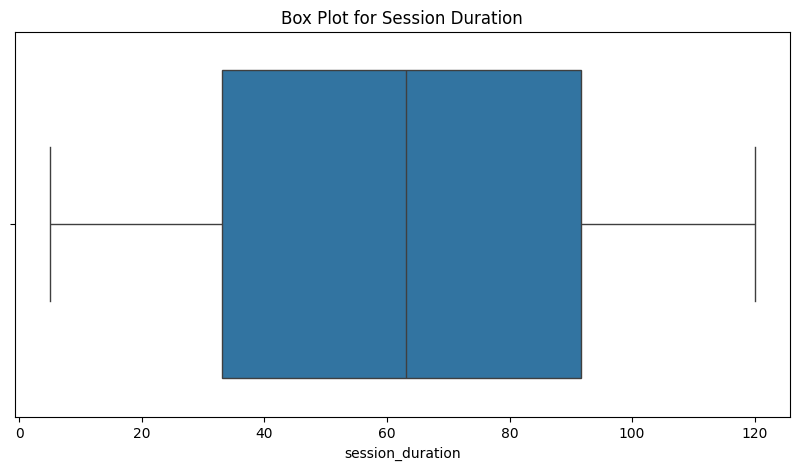

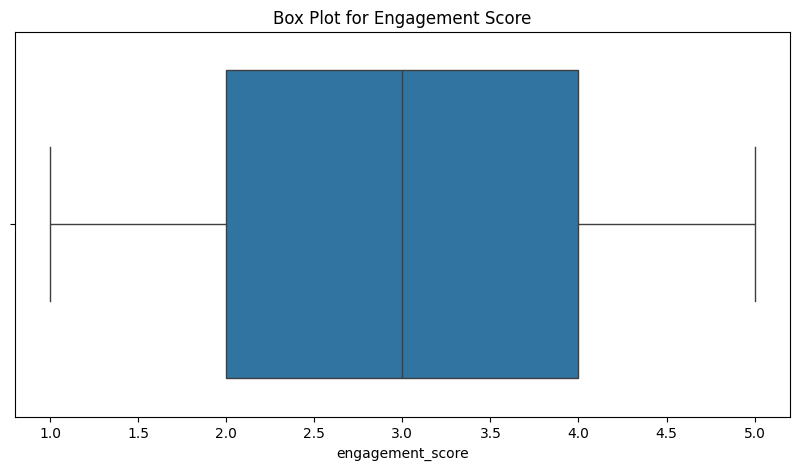

In [16]:
# Visualize session_duration
plt.figure(figsize=(10, 5))
sns.boxplot(x = data['session_duration'])
plt.title('Box Plot for Session Duration')
plt.show()

# Visualize engagement_score
plt.figure(figsize=(10, 5))
sns.boxplot(x = data['engagement_score'])
plt.title('Box Plot for Engagement Score')
plt.show()


From the boxplots, there are no identifiable outliers in `session_duration` and `engagement_score`.

##### High Accessibility User Classification

In [17]:
# Add high_accessibility_user column : Binary column (1 for True, 0 for False)
data['high_accessibility_user'] = (data['accessibility_settings'] >= 3).astype(int)
data.head()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user
0,user_4737,Multilingual,60.77,4,4,Teenager,Non-Binary,LGBTQ+,1
1,user_1492,Text-to-Speech,20.20,5,4,Professional,Non-Binary,LGBTQ+,1
2,user_5936,Colorblind Mode,93.78,2,2,Adult,Female,Unknown,0
3,user_5519,Colorblind Mode,26.36,3,1,Adult,Non-Binary,LGBTQ+,0
4,user_1853,High Contrast Mode,91.67,5,1,Young Adult,Male,Unknown,0


I chose binary labeling (1/0) for the `high_accessibility_user` because it simplifies downstream predictive modeling tasks, where I will build a logistic regression model, which can naturally handle binary variables. Moreover, users with multiple accessibility settings (≥ 3) likely have significant needs for inclusive features. By creating these labels, the model will better identify factors influencing this group's engagement and feature adoption, aiding quality recommendations.

##### Intersectionality Analysis

In [18]:
data['intersectionality'] = data['age_group'] + " - " + data['gender'] + " - " + data['additional_attributes']
data.head()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user,intersectionality
0,user_4737,Multilingual,60.77,4,4,Teenager,Non-Binary,LGBTQ+,1,Teenager - Non-Binary - LGBTQ+
1,user_1492,Text-to-Speech,20.20,5,4,Professional,Non-Binary,LGBTQ+,1,Professional - Non-Binary - LGBTQ+
2,user_5936,Colorblind Mode,93.78,2,2,Adult,Female,Unknown,0,Adult - Female - Unknown
3,user_5519,Colorblind Mode,26.36,3,1,Adult,Non-Binary,LGBTQ+,0,Adult - Non-Binary - LGBTQ+
4,user_1853,High Contrast Mode,91.67,5,1,Young Adult,Male,Unknown,0,Young Adult - Male - Unknown


Summary: I imputed the missing values in the `gender` column by assigning `Non-Binary` if `additional_attributes` was `LGBTQ+`. Otherwise, filled the missing value with `Unknown`. Similarly, if `gender` was `Non-Binary` and `additional_attributes` was missing, I assigned `LGBTQ+`. Otherwise, fill the missing value with `Unknown`. There were no outliers in the data. I created the `high_accessibility_user` column with binary labels (1/0). Additionally, I created the column `intersectionality`, combines `age_group`, `gender`, and `additional_attributes`, to facilitate intersectional analysis.